# MTA Subway Data Analysis
### Reading in the Data

**Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like:**

**{('A002','R051','02-00-00','LEXINGTON AVE'): [ ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'], ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'], ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'], ... ] }**

In [1]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime
import collections
from datetime import time
import random
import math
from pprint import pprint
import matplotlib.cm as cm

I'm going to use `pandas` to do everything here. The basic import statement is below, along with a line to handle warnings about changing the data in a particular frame.


In [2]:
raw_data = pd.read_csv("turndata0627.txt")

# the below is a warning about changing values in a DF. I want to change values. I don't listen to the warnings
pd.options.mode.chained_assignment = None   

In order to preserve my own sanity, I'm going to clean the data first, because the turnstile counters are not a good way of ascertaining counts.


In [3]:
#initial data cleaning to eliminate turnstile default vals  
def clean_data(inp):
    data = inp.copy(deep="True")
    data['ENTRIES2'] = 0
    
    # remove 
    for i in range(1, len(data)):
        
        if data['SCP'][i] == data['SCP'][i-1]:
            data['ENTRIES2'][i] = data['ENTRIES'][i] - data['ENTRIES'][i-1]
    
    for i in range(0, len(data)):
        # fix values that are too high or too low                                                               
        if data['ENTRIES2'][i] > 5000:
            data['ENTRIES2'][i] = 0 # try this instead of plain old zero
        if data['ENTRIES2'][i] < 0:
            data['ENTRIES2'][i] = 0
    
    # overwrite original ENTRIES data because it's not useful
    data['ENTRIES'] = data['ENTRIES2']
    return data.copy(deep="True")

df = clean_data(raw_data)

### Make a Station Map

**We want to combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.**

In [4]:
series = df.groupby(['STATION','LINENAME','DATE'])['ENTRIES'].sum()

def station_map(series):
    '''Make a dictionary of STATION[date, count] pairs for a given series'''
    dict = {}
    for row in series.iteritems():

        #grab row data 
        date = datetime.strptime(row[0][2], '%m/%d/%Y')
        key = str(row[0][0]) + " " + str(row[0][1])
        entry = row[1]
        value = [date, entry]

        #add to or update dict                                                                                           
        if key in dict:
            dict[key].append(value)
        else:
            dict[key]=[value]
    return dict

# test
weekly_station_map = station_map(series)

###Aggregating Data

**Read in more data so we can use it!**

We're going to need more data for the second part of that! Lets import some more files and clean them.

In [5]:
raw_data0620 = pd.read_csv("turndata0620.txt", low_memory=False) 
raw_data0613 = pd.read_csv("turndata0613.txt", low_memory=False)
raw_data0606 = pd.read_csv("turndata0606.txt", low_memory=False)

In [6]:
week1 = clean_data(raw_data0620) 
week2 = clean_data(raw_data0613)
week3 = clean_data(raw_data0606)

In [7]:
STATION = random.choice(weekly_station_map.keys()) # choose a random station

def weekmap(dictionary):
    # store vals in weeks dict                                                               
    weeks = {'Sunday': 0,
             'Monday': 0,
             'Tuesday': 0,
             'Wednesday': 0,
             'Thursday': 0,
             'Friday': 0,
             'Saturday': 0
             }
    # this dictionary maps the indices of the list weeks.keys to the actual order of the data
    days = {1: 'Sunday',
            2: 'Monday',
            3: 'Tuesday',
            4: 'Wednesday',
            5: 'Thursday',
            6: 'Friday',
            0: 'Saturday'
            }

    day = 0
    day_index = ''
    for key in weeks.keys():
        day_index = days[day] # guarantee you're picking the right day by actually calling the day, not a number                      
        weeks[day_index] = dictionary[STATION][day][1]
        day += 1
    return weeks

# test
initial_weekmap = weekmap(weekly_station_map)
print(STATION, initial_weekmap)

('28 ST 1', {'Monday': 14972, 'Tuesday': 16516, 'Friday': 15410, 'Wednesday': 16144, 'Thursday': 15992, 'Sunday': 5156, 'Saturday': 5337})


Now lets do this again for the other weeks!

In [8]:
# get series
series1 = week1.groupby(['STATION','LINENAME','DATE'])['ENTRIES'].sum()
series2 = week2.groupby(['STATION','LINENAME', 'DATE'])['ENTRIES'].sum()
series3 = week3.groupby(['STATION','LINENAME','DATE'])['ENTRIES'].sum()

# now get a weekly map
weekly_station_map1 = station_map(series1)
weekly_station_map2 = station_map(series2)
weekly_station_map3 = station_map(series3)

# now transform them to days of the week
weekmap1 =  weekmap(weekly_station_map1)
weekmap2 =  weekmap(weekly_station_map2)
weekmap3 =  weekmap(weekly_station_map3)

Now we can compine all of these "week maps" into a single plot

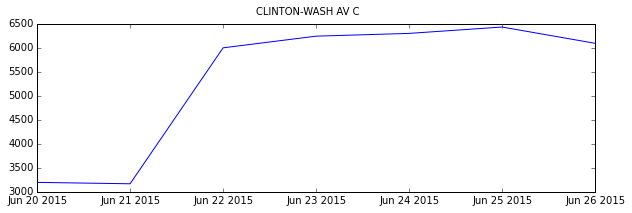

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = iter(cm.rainbow(np.linspace(0, 1, 4))) 
stn_name = random.choice(weekly_station_map.keys()) # choose a random station

station = weekly_station_map[stn_name] # grap the associated dictionary values
dates = [x[0] for x in station]
entries = [x[1] for x in station]
plt.figure(figsize=(10,3)).suptitle(str(stn_name), fontsize='10')
plt.plot(dates, entries)

### Total Ridership Over the month of June

**Over the month of June, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate**

Lets start by transforming the data from the above into a concatenated `df` object. 

In [10]:
file_list = []
total_df = None
file_list.append(df)
file_list.append(week1)
file_list.append(week2)
file_list.append(week3)
total_df = pd.concat(file_list)

In [ ]:
month_data = total_df.groupby(['STATION', 'LINENAME'])['ENTRIES'].sum()

totals = {}

for row in month_data.iteritems():                          
    key = str(str(row[0][0]) + " " + str(row[0][1])) # combine station and linename
    value = row[1]
    if key in totals:
        totals[key] += value
    else:
        totals[key] = value
        
sorted_total = sorted(totals.items(), key=lambda x: (-x[1], x[0])) 
pprint(sorted_total[:20])

### Distribution of Ridership Across Stations

**Make a single list of these total ridership values and plot it with plt.hist(total_ridership_counts)to get an idea about the distribution of total ridership among different stations.**

**This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.**


(array([ 366.,   74.,   19.,    7.,    2.,    3.,    0.,    1.,    0.,    1.]),
 array([  3.78100000e+03,   3.82817400e+05,   7.61853800e+05,
          1.14089020e+06,   1.51992660e+06,   1.89896300e+06,
          2.27799940e+06,   2.65703580e+06,   3.03607220e+06,
          3.41510860e+06,   3.79414500e+06]),
 <a list of 10 Patch objects>)

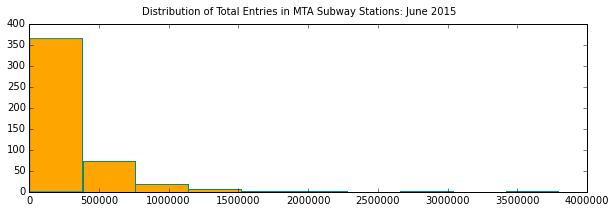

In [57]:
total_ridership_counts = totals.values()
plt.figure(figsize=(10,3)).suptitle(str('Distribution of Total Entries in MTA Subway Stations: June 2015'), fontsize='10')
plt.hist(total_ridership_counts, color ='orange', edgecolor='darkcyan')

### Distribution of Ridership Across Time Periods

**We want to know if there's a particular time which is best for WTWY to be in the subway station entrances**

**To do this, lets first investigate when is the best time for all of the stations, and then do the same for just the stations with the most ridership**

([<matplotlib.axis.XTick at 0x11e013350>,
 <a list of 24 Text xticklabel objects>)

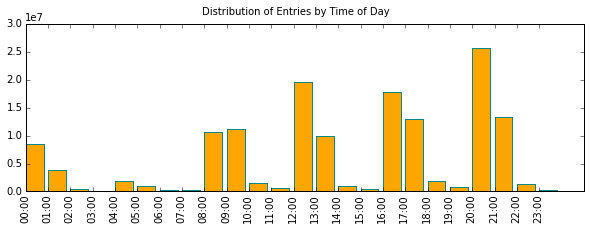

In [56]:
time_bin_data = total_df.groupby(['TIME'])['ENTRIES'].sum()
time_bin_dict = {}

for row in time_bin_data.iteritems():
    time_bin = row[0][:2] + ":00"
    value = row[1]
    
    if time_bin in time_bin_dict:
        time_bin_dict[time_bin] += value
    else:
        time_bin_dict[time_bin] = value

sorted_time_bins = collections.OrderedDict(sorted(time_bin_dict.items()))
plt.figure(figsize=(10,3)).suptitle(str('Distribution of Entries by Time of Day'), fontsize='10')
plt.bar(range(len(time_bin_dict)), sorted_time_bins.values(), color='orange', edgecolor='darkcyan')
plt.xticks(range(len(time_bin_dict)), sorted_time_bins.keys(), rotation =90)

([<matplotlib.axis.XTick at 0x12d496a50>,
 <a list of 24 Text xticklabel objects>)

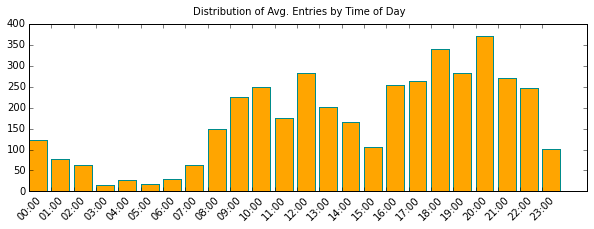

In [54]:
time_bin_array = {}
time_bin_avg = {}

for index, row in total_df.iterrows(): 
    #grab row                   
    
    r = row.values.tolist()
    key = r[7][:2] + ":00" #time
    val = r[9] #entries
    
    if key in time_bin_array:
        time_bin_array[key].append(val)
    else:
        time_bin_array[key] = [val]
        
for key in time_bin_array:
    time_bin_avg[key] = np.average(time_bin_array[key])
    
sorted_time_bins = collections.OrderedDict(sorted(time_bin_avg.items()))

plt.figure(figsize=(10,3)).suptitle(str('Distribution of Avg. Entries by Time of Day'),fontsize='10')
plt.bar(range(len(time_bin_avg)), sorted_time_bins.values(), color='orange', edgecolor='darkcyan')
plt.xticks(range(len(time_bin_avg)), sorted_time_bins.keys(), rotation=45)

([<matplotlib.axis.XTick at 0x1201a5510>,
 <a list of 15 Text xticklabel objects>)

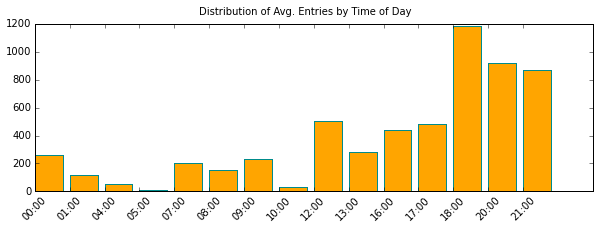

In [53]:
%matplotlib inline
''' get data for:
 ('42 ST-GRD CNTRL 4567S'),
 ('34 ST-HERALD SQ BDFMNQR'),
 ('42 ST-TIMES SQ 1237ACENQRS'),
 ('34 ST-PENN STA ACE'),
 ('42 ST-PA BUS TE ACENQRS1237')
'''

# add column to df for easy manipulation
total_df['STATION + LINE'] = total_df['STATION'] + " " + total_df['LINENAME']

# create sub-df's for our top five stations
df_GST = total_df[total_df['STATION + LINE'] == '42 ST-GRD CNTRL 4567S']

# create series for top five stations
time_bin_array = {}
time_bin_avg = {}

for index, row in df_GST.iterrows(): 
    #grab row                   
    
    r = row.values.tolist()
    key = r[7][:2] + ":00" #time
    val = r[9] #entries
    
    if key in time_bin_array:
        time_bin_array[key].append(val)
    else:
        time_bin_array[key] = [val]
        
for key in time_bin_array:
    time_bin_avg[key] = np.average(time_bin_array[key])
    
sorted_time_bins = collections.OrderedDict(sorted(time_bin_avg.items()))

plt.figure(figsize=(10,3)).suptitle(str('Distribution of Avg. Entries by Time of Day'),fontsize='10')
plt.bar(range(len(time_bin_avg)), sorted_time_bins.values(), color='orange', edgecolor='darkcyan')
plt.xticks(range(len(time_bin_avg)), sorted_time_bins.keys(), rotation=45)